<a href="https://colab.research.google.com/github/Manikanta898/Customer-Churn-Analysis/blob/main/Customer_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Summary**

This project focuses on the initial steps of building a customer churn predictive model, including data collection, exploratory data analysis (EDA), and data preprocessing to ensure quality and accuracy in later modeling stages.


# **GitHub Link**

https://github.com/Manikanta898/Customer-Churn-Analysis

# **Rationale for Each Data Set**

The following data sets were identified as relevant for predicting customer churn:

---

* **Customer Demographics** – Understand customer profiles and segmentation.
* **Transaction History** – Measure engagement and spending behavior.
* **Customer Service Interactions** – Identify dissatisfaction or service issues.
* **Online Activity** – Track digital engagement and usage patterns.
* **Churn Status** – Target variable needed for churn prediction modeling.

---


These data sets provide comprehensive insights into customer behaviour and engagement.


### Import Libraries

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Dataset Loading

In [ ]:
import pandas as pd

path = '/content/Customer_Churn_Data_Large.xlsx'

# Get all sheet names
sheet_names = pd.ExcelFile(path).sheet_names
print(sheet_names)

# Load each sheet
demographics_df = pd.read_excel(path, sheet_name='Customer_Demographics')
transactions_df = pd.read_excel(path, sheet_name='Transaction_History')
service_df = pd.read_excel(path, sheet_name='Customer_Service')
churn_df = pd.read_excel(path, sheet_name='Churn_Status')

# Merge all data using CustomerID
df = demographics_df.merge(transactions_df, on='CustomerID', how='left') \
                    .merge(service_df, on='CustomerID', how='left') \
                    .merge(churn_df, on='CustomerID', how='left')

# Dataset First Look
df.head()

['Customer_Demographics', 'Transaction_History', 'Customer_Service', 'Online_Activity', 'Churn_Status']


,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TransactionID,TransactionDate,AmountSpent,ProductCategory,InteractionID,InteractionDate,InteractionType,ResolutionStatus,ChurnStatus
0,1,62,M,Single,Low,7194,2022-03-27,416.50,Electronics,6363.0,2022-03-31,Inquiry,Resolved,0
1,2,65,M,Married,Low,7250,2022-08-08,54.96,Clothing,3329.0,2022-03-17,Inquiry,Resolved,1
2,2,65,M,Married,Low,9660,2022-07-25,197.50,Electronics,3329.0,2022-03-17,Inquiry,Resolved,1
3,2,65,M,Married,Low,2998,2022-01-25,101.31,Furniture,3329.0,2022-03-17,Inquiry,Resolved,1
4,2,65,M,Married,Low,1228,2022-07-24,397.37,Clothing,3329.0,2022-03-17,Inquiry,Resolved,1


### Dataset Information

In [ ]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        6812 non-null   int64         
 1   Age               6812 non-null   int64         
 2   Gender            6812 non-null   object        
 3   MaritalStatus     6812 non-null   object        
 4   IncomeLevel       6812 non-null   object        
 5   TransactionID     6812 non-null   int64         
 6   TransactionDate   6812 non-null   datetime64[ns]
 7   AmountSpent       6812 non-null   float64       
 8   ProductCategory   6812 non-null   object        
 9   InteractionID     5204 non-null   float64       
 10  InteractionDate   5204 non-null   datetime64[ns]
 11  InteractionType   5204 non-null   object        
 12  ResolutionStatus  5204 non-null   object        
 13  ChurnStatus       6812 non-null   int64         
dtypes: datetime64[ns](2), fl

# **Exploratory Data Analysis**

#### Churn Rate by Gender

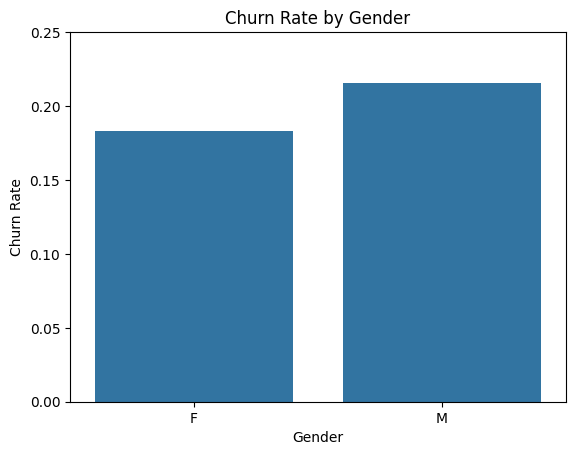

In [ ]:
# Calculate churn rate by gender
churn_rate_gender = df.groupby('Gender')['ChurnStatus'].mean().reset_index()
churn_rate_gender.rename(columns={'ChurnStatus': 'ChurnRate'}, inplace=True)

sns.barplot(x='Gender', y='ChurnRate', data=churn_rate_gender)
plt.title('Churn Rate by Gender')
plt.ylabel('Churn Rate')
plt.xlabel('Gender')
plt.ylim(0, 0.25)  # Churn rate is between 0 and .25
plt.show()

Understanding gender differences in churn helps design focused retention campaigns that address specific needs and reduce customer loss.

#### Churn Status by Resolution Status

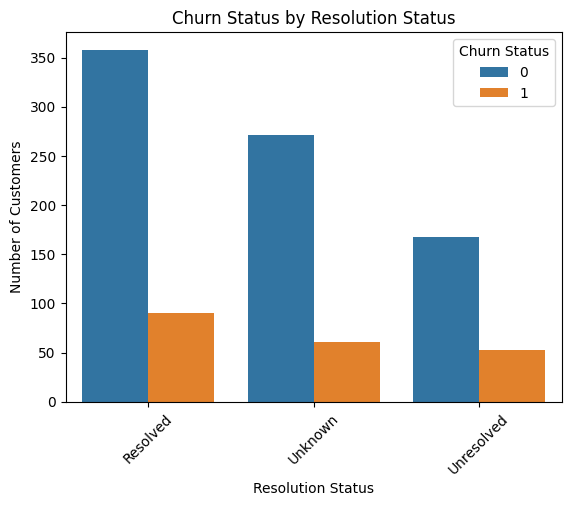

In [ ]:
# Get most frequent ResolutionStatus per customer
resolution_summary = df.groupby('CustomerID').agg({
    'ResolutionStatus': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
    'ChurnStatus': 'first'
}).reset_index()

sns.countplot(x='ResolutionStatus', hue='ChurnStatus', data=resolution_summary)
plt.title('Churn Status by Resolution Status')
plt.xlabel('Resolution Status')
plt.ylabel('Number of Customers')
plt.legend(title='Churn Status')
plt.xticks(rotation=45)
plt.show()

Recognizing which resolution outcomes lead to churn allows improving customer service processes to boost satisfaction and loyalty.

#### Age distribution of customers

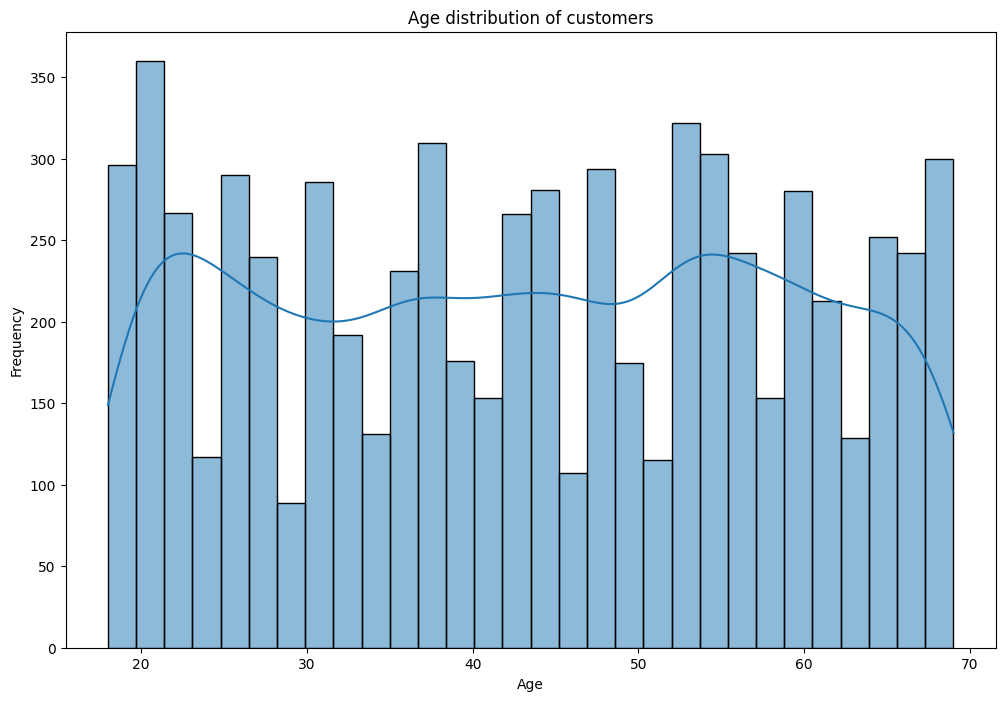

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(data=df, x='Age', bins=30, kde=True)
plt.title('Age distribution of customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Knowing the main age groups in your customer base enables tailored marketing and product offers that better resonate with your audience.

#### Total Amount Spent by Gender and Churn Status

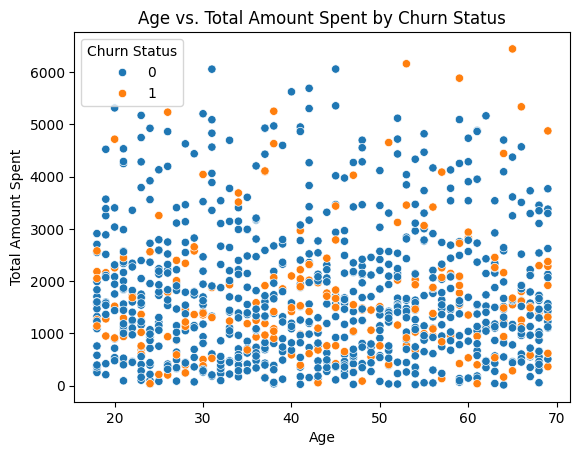

In [ ]:
# Aggregate total spend and get customer demographics + churn
age_spending_df = df.groupby('CustomerID').agg({
    'Age': 'first',
    'AmountSpent': 'sum',
    'ChurnStatus': 'first'
}).rename(columns={'AmountSpent': 'TotalAmountSpent'}).reset_index()

sns.scatterplot(
    data=age_spending_df,
    x='Age',
    y='TotalAmountSpent',
    hue='ChurnStatus'
)

plt.title('Age vs. Total Amount Spent by Churn Status')
plt.xlabel('Age')
plt.ylabel('Total Amount Spent')
plt.legend(title='Churn Status')
plt.show()

Analyzing spending and churn across ages helps prioritize retention efforts on high-value customers likely to leave.

# **Data cleaning & Pre-processing**

#### Handle Missing Values

In [ ]:
# Create a copy of the original DataFrame
df_copy = df.copy()

# Drop unneeded ID columns from the copy
df_copy.drop(['CustomerID', 'TransactionID', 'InteractionID'], axis=1, inplace=True)

# Calculate the count of missing values for each column
missing_count = df_copy.isnull().sum()

# Calculate the percentage of missing values for each column
missing_percentage = (df_copy.isnull().sum() / len(df_copy)) * 100

# Combine both into a DataFrame
missing_info = pd.DataFrame({
    'Missing Values Count': missing_count,
    'Missing Values Percentage': missing_percentage
})

# Display the result
print(missing_info)

# Drop rows with missing InteractionDate
df_copy.dropna(subset=['InteractionDate'], inplace=True)

# Impute missing InteractionType and ResolutionStatus with mode
df_copy['InteractionType'].fillna(df_copy['InteractionType'].mode()[0], inplace=True)
df_copy['ResolutionStatus'].fillna(df_copy['ResolutionStatus'].mode()[0], inplace=True)

                  Missing Values Count  Missing Values Percentage
Age                                  0                   0.000000
Gender                               0                   0.000000
MaritalStatus                        0                   0.000000
IncomeLevel                          0                   0.000000
TransactionDate                      0                   0.000000
AmountSpent                          0                   0.000000
ProductCategory                      0                   0.000000
InteractionDate                   1608                  23.605402
InteractionType                   1608                  23.605402
ResolutionStatus                  1608                  23.605402
ChurnStatus                          0                   0.000000


/tmp/ipython-input-3229489844.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['InteractionType'].fillna(df_copy['InteractionType'].mode()[0], inplace=True)
/tmp/ipython-input-3229489844.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[co

Handles missing values using mode for categorical features; drops rows missing date information.

### Detect and Remove Outliers

In [ ]:
from scipy import stats

num_cols = ['Age', 'AmountSpent']
z_scores = np.abs(stats.zscore(df_copy[num_cols]))
df_copy = df_copy[(z_scores < 3).all(axis=1)]  # Keep rows where all z-scores < 3

Removes rows where Age or AmountSpent values are beyond 3 standard deviations, helping prevent skewed model training due to extreme values.

### Standardize Numerical Columns

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_copy[['Age', 'AmountSpent']] = scaler.fit_transform(df_copy[['Age', 'AmountSpent']])

Standardizes numerical columns to have zero mean and unit variance

### Categorical Encoding

In [ ]:
# Encode your categorical columns
from sklearn.preprocessing import OneHotEncoder

# Categorical columns to one-hot encode (excluding target)
cat_cols = ['Gender', 'MaritalStatus', 'IncomeLevel', 'ProductCategory', 'InteractionType', 'ResolutionStatus']

# One-hot encode categorical variables
df_copy = pd.get_dummies(df_copy, columns=cat_cols, drop_first=True)

Applies one-hot encoding to selected categorical features in df_copy and converts the ChurnStatus target variable to a binary numeric format.

# **Model Building & Training**

### Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df_copy.drop('ChurnStatus', axis=1)
y = df_copy['ChurnStatus']

# Drop datetime columns
X = X.drop(['TransactionDate', 'InteractionDate'], axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4163, 15)
Shape of X_test: (1041, 15)
Shape of y_train: (4163,)
Shape of y_test: (1041,)


Splitting the dataset into training and testing sets ensures that the model is evaluated on unseen data, which provides an unbiased estimate of its real-world performance. Using stratification maintains the original class distribution, which is crucial for balanced evaluation in imbalanced classification problems like churn prediction.

### Cross-Validation + Random Forest with Hyperparameter Tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestClassifier(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='f1', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

# Best estimator
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV with cross-validation systematically searches through combinations of hyperparameters, ensuring the model is optimized for the best predictive performance. Cross-validation helps reduce overfitting by validating the model on multiple data folds, resulting in a more robust and generalized Random Forest classifier.

### Model Evaluation

Confusion Matrix:
 [[803  24]
 [ 82 132]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       827
           1       0.85      0.62      0.71       214

    accuracy                           0.90      1041
   macro avg       0.88      0.79      0.83      1041
weighted avg       0.89      0.90      0.89      1041

ROC-AUC Score: 0.95


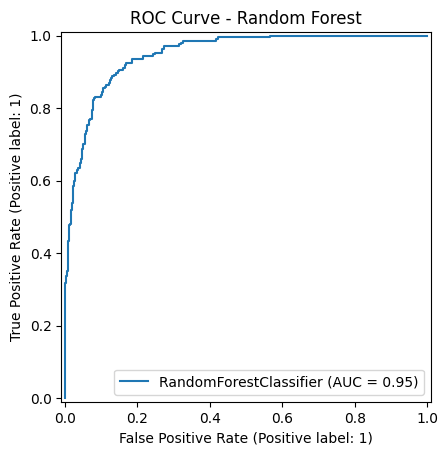

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Predict
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]  # For ROC-AUC

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# ROC Curve
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()


Using metrics such as precision, recall, F1-score, confusion matrix, and ROC-AUC provides a comprehensive assessment of the model’s ability to correctly identify churners and non-churners. This helps understand the trade-offs in model performance and ensures the chosen model is effective in predicting customer churn with a high degree of reliability.

# Recommendations and Business Implications

- Unresolved customer service interactions are linked to higher churn rates. Improving issue resolution processes can significantly reduce customer attrition.

- Certain demographic groups, like gender and marital status segments, show higher churn, so tailored marketing and retention campaigns are essential.

- Customers who spend more but are likely to churn should be prioritized for loyalty programs to protect revenue.

- The high-performing Random Forest model (90% accuracy, 95% ROC-AUC) can be embedded into CRM systems to proactively identify and retain at-risk customers.

- Addressing missing data in key features (like interaction details) is crucial to improve model reliability and decision-making.

- Incorporating online activity data in future models can boost predictive power and uncover new churn drivers.